In [1]:
import os
import sys
import time

verbose  = os.environ.get('RADICAL_PILOT_VERBOSE', 'REPORT')
os.environ['RADICAL_PILOT_VERBOSE'] = verbose

import radical.pilot as rp
import radical.utils as ru

from rose.learner import ReinforcementLearner
from rose.engine import Task, ResourceEngine
from rose.metrics import GREATER_THAN_THRESHOLD

In [2]:
engine = ResourceEngine({'runtime': 30,
                         'resource': 'local.localhost'})
rl = ReinforcementLearner(engine)
code_path = f'{sys.executable} {os.getcwd()}'
data_path = os.path.join(os.getcwd(), 'data')
os.makedirs(data_path, exist_ok=True)

Resource Engine started successfully

Task 'environment' ready to submit; resolved dependencies: []
Task 'environment' ready to submit; resolved dependencies: []
Task 'environment' ready to submit; resolved dependencies: []
Task 'environment' ready to submit; resolved dependencies: []
Task 'environment' ready to submit; resolved dependencies: []
submitting ['environment', 'environment', 'environment', 'environment', 'environment'] for execution
task.000000 is DONE
task.000004 is DONE
task.000002 is DONE
task.000003 is DONE
task.000001 is DONE
Task 'merge' ready to submit; resolved dependencies: []
submitting ['merge'] for execution
task.000005 is DONE
Task 'update' ready to submit; resolved dependencies: ['merge']
submitting ['update'] for execution
task.000006 is DONE
Task 'check_reward' ready to submit; resolved dependencies: ['update']
submitting ['check_reward'] for execution
task.000007 is DONE
Task 'environment' ready to submit; resolved dependencies: []
Task 'environment' ready 

In [3]:
# Define and register the environment task
@rl.environment_task
def environment(shard, *args):
    return Task(executable=f'{code_path}/environment.py {shard} {data_path}', arguments=args)

# Define and register the policy update task
@rl.update_task
def update(*args):
    return Task(executable=f'{code_path}/update.py {data_path}', arguments=args)

@rl.utility_task
def merge(*args):
    return Task(executable=f'{code_path}/merge_memory.py {data_path}', arguments=args)

@rl.as_stop_criterion(metric_name='MODEL_REWARD', threshold=100, operator=GREATER_THAN_THRESHOLD)
def check_reward(*args):
    return Task(executable=f'{code_path}/check_reward.py {data_path}', arguments=args)

In [4]:
# Custom teaching loop with reinforcement Learning
rewards = []
def teach():
    for iter in range(20):
        envs = []
        for i in range(5):
            env = environment(i)
            envs.append(env)
        [env.result() for env in envs]
        mrg = merge()
        upd = update(mrg)
        should_stop, reward = check_reward(upd);
        rewards.append(reward)
        if should_stop:
            break
# invoke the custom/user-defined teach() method
teach()

Registered task 'environment' and id of 000000 with dependencies: []
Registered task 'environment' and id of 000001 with dependencies: []
Registered task 'environment' and id of 000002 with dependencies: []
Registered task 'environment' and id of 000003 with dependencies: []
Registered task 'environment' and id of 000004 with dependencies: []
Registered task 'merge' and id of 000005 with dependencies: []
Registered task 'update' and id of 000006 with dependencies: ['merge']
Registered task 'check_reward' and id of 000007 with dependencies: ['update']
stop criterion metric: MODEL_REWARD is not met yet (9.3).
Registered task 'environment' and id of 000008 with dependencies: []
Registered task 'environment' and id of 000009 with dependencies: []
Registered task 'environment' and id of 000010 with dependencies: []
Registered task 'environment' and id of 000011 with dependencies: []
Registered task 'environment' and id of 000012 with dependencies: []
Registered task 'merge' and id of 000013

In [5]:
engine.shutdown()

Shutdown is triggered, terminating the resources gracefully


Text(0.5, 1.0, 'Reward During Reinforcement Learning')

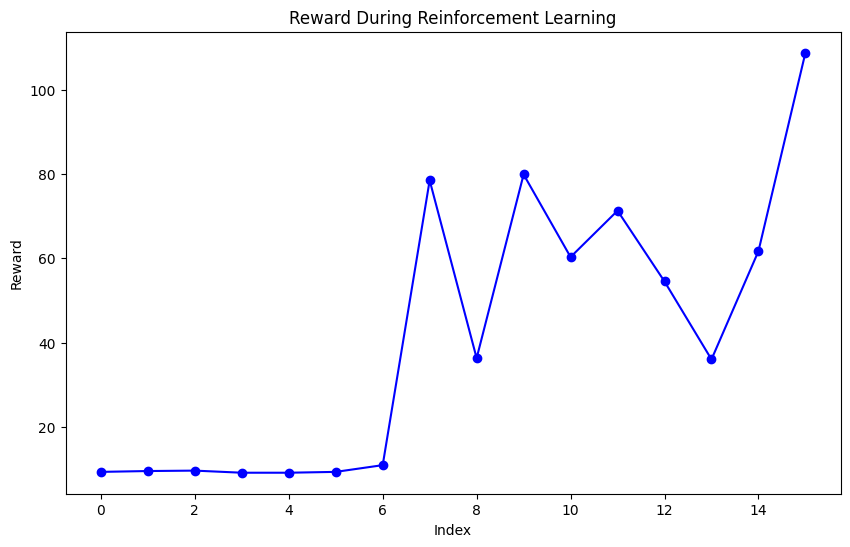

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(rewards, marker='o', color='b', linestyle='-', markersize=6)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Reward')
plt.title('Reward During Reinforcement Learning')